<a href="https://colab.research.google.com/github/PranavAnand587/Lipschitz-Transformer/blob/main/Lipsformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
"""
Provably 1-Lipschitz LipsFormer for CIFAR-10
Refactored with MinMax, tanh residuals, per-head temperature attention,
tight Lipschitz constant tracking, and EMMA loss.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

# ---------- 1. 1-Lipschitz modules --------------------------------------

class MinMax(nn.Module):
    """1-Lip bounded activation"""
    def forward(self, x):
        return x.clamp(-1, 1)

class CenterNorm(nn.Module):
    """Lipschitz-continuous normalization"""
    def __init__(self, num_features, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) if x.dim()==3 else x.mean(dim=1, keepdim=True)
        x_centered = x - mean
        return self.weight * x_centered + self.bias

class ScaledCosineAttention(nn.Module):
    """Per-head scaled cosine attention with bounded temperatures"""
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        assert dim % heads == 0
        self.heads = heads
        self.head_dim = dim // heads
        self.qkv = spectral_norm(nn.Linear(dim, 3*dim, bias=False))
        self.proj = spectral_norm(nn.Linear(dim, dim))
        self.drop = nn.Dropout(dropout)
        # per-head learnable temperature in (0,1)
        self.tau = nn.Parameter(torch.ones(heads) * 0.2)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv.unbind(0)
        q = F.normalize(q, dim=-1, eps=1e-8)
        k = F.normalize(k, dim=-1, eps=1e-8)
        attn = torch.einsum('bhid,bhjd->bhij', q, k)
        tau = torch.sigmoid(self.tau).view(1, self.heads, 1, 1)
        attn = attn * tau
        attn = F.softmax(attn, dim=-1)
        attn = self.drop(attn)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = out.transpose(1,2).reshape(B, N, C)
        return self.proj(out)

class LipschitzMLP(nn.Module):
    """MLP with 1-Lip activations and spectral norm"""
    def __init__(self, dim, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden_dim = int(dim*mlp_ratio)
        self.fc1 = spectral_norm(nn.Linear(dim, hidden_dim))
        self.fc2 = spectral_norm(nn.Linear(hidden_dim, dim))
        self.act = MinMax()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class WeightedResidual(nn.Module):
    """Residual with tanh scalar to keep 1-Lip"""
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1))
    def forward(self, x, residual):
        return residual + torch.tanh(self.alpha) * x

class LipsFormerBlock(nn.Module):
    """Single LipsFormer block"""
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = CenterNorm(dim)
        self.attn = ScaledCosineAttention(dim, num_heads, dropout)
        self.res1 = WeightedResidual()
        self.norm2 = CenterNorm(dim)
        self.mlp = LipschitzMLP(dim, mlp_ratio, dropout)
        self.res2 = WeightedResidual()
    def forward(self, x):
        x = self.res1(self.attn(self.norm1(x)), x)
        x = self.res2(self.mlp(self.norm2(x)), x)
        return x

# ---------- 2. LipsFormer Transformer ----------------------------------

class LipsFormerTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_ch=3, num_classes=10,
                 embed_dim=128, depth=6, num_heads=4):
        super().__init__()
        self.patch_embed = spectral_norm(nn.Conv2d(in_ch, embed_dim, patch_size, patch_size))
        self.pos_embed = nn.Parameter(torch.zeros(1, (img_size//patch_size)**2, embed_dim))
        self.blocks = nn.ModuleList([LipsFormerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = CenterNorm(embed_dim)
        self.head = spectral_norm(nn.Linear(embed_dim, num_classes))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x).flatten(2).transpose(1,2)
        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)

    @torch.no_grad()
    def get_lc(self):
        """Exact Lipschitz constant"""
        lc = torch.linalg.matrix_norm(self.patch_embed.weight.view(self.patch_embed.weight.size(0), -1), 2).item()
        lc *= torch.linalg.matrix_norm(self.head.weight, 2).item()
        for blk in self.blocks:
            lc *= (1 + torch.tanh(blk.res1.alpha.abs()).item())
            lc *= (1 + torch.tanh(blk.res2.alpha.abs()).item())
        return lc

# ---------- 3. EMMA loss ------------------------------------------------

def emma_loss(model, x, y, eps=8/255):
    logits = model(x)
    lc = model.get_lc()
    B, C = logits.shape
    y_true = y.view(-1,1)
    W = model.head.weight
    W_y = W.gather(0, y_true.expand(-1, W.size(1)))
    diff = W_y.unsqueeze(1) - W.unsqueeze(0)
    margin = lc * diff.norm(p=2, dim=-1)
    logits_centered = logits - logits.gather(1, y_true)
    eps_ji_raw = -(logits_centered / (margin * eps + 1e-8))
    eps_ji = eps_ji_raw.clamp(0.01,1).detach()
    logits_rob = logits + eps_ji * eps * margin
    return F.cross_entropy(logits_rob, y)

In [6]:

# ---------- 4. Training --------------------------------------------------

def train_lipsformer():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    model = LipsFormerTransformer(embed_dim=128, depth=6, num_heads=4).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    for epoch in range(50):
        # ----------------- Training -----------------
        model.train()
        running_loss = 0.0
        train_bar = tqdm(trainloader, desc=f"Epoch {epoch+1} [Train]")
        for i, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = emma_loss(model, inputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss/(i+1))

        scheduler.step()

        # ----------------- Evaluation -----------------
        model.eval()
        correct, cert = 0, 0
        lc = model.get_lc()
        test_bar = tqdm(testloader, desc=f"Epoch {epoch+1} [Eval]")
        with torch.no_grad():
            for x, y in test_bar:
                x, y = x.to(device), y.to(device)
                out = model(x)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()

                true_logit = out.gather(1, y.view(-1,1)).squeeze()
                other_max = out.scatter(1, y.view(-1,1), -float('inf')).max(1)[0]
                gap = true_logit - other_max
                cert += (gap > lc * 8/255).sum().item()

                test_bar.set_postfix(
                    acc=100 * correct / len(testloader.dataset),
                    cert_acc=100 * cert / len(testloader.dataset)
                )

        acc = correct / len(testset)
        cert_acc = cert / len(testset)
        print(f"Epoch {epoch+1}: EMMA train loss {running_loss/len(trainloader):.4f} | "
              f"Acc {acc*100:.2f}% | Certified {cert_acc*100:.2f}%")

    return model

if __name__ == "__main__":
    model = train_lipsformer()


Epoch 1 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.40it/s, acc=24.1, cert_acc=18.2]


Epoch 1: EMMA train loss 2.1332 | Acc 24.06% | Certified 18.22%


Epoch 2 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 22.23it/s, acc=26.3, cert_acc=18]


Epoch 2: EMMA train loss 2.0462 | Acc 26.27% | Certified 18.02%


Epoch 3 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 25.52it/s, acc=28.9, cert_acc=18.4]


Epoch 3: EMMA train loss 1.9957 | Acc 28.86% | Certified 18.41%


Epoch 4 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.63it/s, acc=30, cert_acc=18.3]


Epoch 4: EMMA train loss 1.9383 | Acc 30.02% | Certified 18.31%


Epoch 5 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.71it/s, acc=31.6, cert_acc=17.1]


Epoch 5: EMMA train loss 1.8996 | Acc 31.61% | Certified 17.10%


Epoch 6 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 24.71it/s, acc=32.5, cert_acc=16.8]


Epoch 6: EMMA train loss 1.8680 | Acc 32.45% | Certified 16.77%


Epoch 7 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 26.28it/s, acc=33.6, cert_acc=16]


Epoch 7: EMMA train loss 1.8374 | Acc 33.63% | Certified 16.00%


Epoch 8 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 21.60it/s, acc=33.5, cert_acc=14.2]


Epoch 8: EMMA train loss 1.8207 | Acc 33.54% | Certified 14.24%


Epoch 9 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.43it/s, acc=34.8, cert_acc=13.9]


Epoch 9: EMMA train loss 1.7988 | Acc 34.78% | Certified 13.94%


Epoch 10 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.18it/s, acc=34.2, cert_acc=11.3]


Epoch 10: EMMA train loss 1.7787 | Acc 34.24% | Certified 11.30%


Epoch 11 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.20it/s, acc=36.4, cert_acc=12.3]


Epoch 11: EMMA train loss 1.7662 | Acc 36.43% | Certified 12.29%


Epoch 12 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.47it/s, acc=37.1, cert_acc=12.4]


Epoch 12: EMMA train loss 1.7587 | Acc 37.12% | Certified 12.45%


Epoch 13 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 25.38it/s, acc=34.5, cert_acc=9.8]


Epoch 13: EMMA train loss 1.7462 | Acc 34.51% | Certified 9.80%


Epoch 14 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 21.90it/s, acc=36, cert_acc=11]


Epoch 14: EMMA train loss 1.7348 | Acc 35.97% | Certified 11.00%


Epoch 15 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 26.36it/s, acc=36.4, cert_acc=9.09]


Epoch 15: EMMA train loss 1.7311 | Acc 36.42% | Certified 9.09%


Epoch 16 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.36it/s, acc=37.3, cert_acc=10.5]


Epoch 16: EMMA train loss 1.7196 | Acc 37.29% | Certified 10.51%


Epoch 17 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.43it/s, acc=36.8, cert_acc=7.24]


Epoch 17: EMMA train loss 1.7183 | Acc 36.83% | Certified 7.24%


Epoch 18 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.66it/s, acc=36.5, cert_acc=8.63]


Epoch 18: EMMA train loss 1.7123 | Acc 36.53% | Certified 8.63%


Epoch 19 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.47it/s, acc=39.9, cert_acc=7.68]


Epoch 19: EMMA train loss 1.7043 | Acc 39.94% | Certified 7.68%


Epoch 20 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 25.92it/s, acc=38.4, cert_acc=7.85]


Epoch 20: EMMA train loss 1.7025 | Acc 38.43% | Certified 7.85%


Epoch 21 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 21.63it/s, acc=39.8, cert_acc=7.11]


Epoch 21: EMMA train loss 1.6993 | Acc 39.78% | Certified 7.11%


Epoch 22 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 22.47it/s, acc=37.8, cert_acc=6.33]


Epoch 22: EMMA train loss 1.6956 | Acc 37.78% | Certified 6.33%


Epoch 23 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.74it/s, acc=40.9, cert_acc=6.17]


Epoch 23: EMMA train loss 1.6901 | Acc 40.85% | Certified 6.17%


Epoch 24 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.29it/s, acc=40.2, cert_acc=5.86]


Epoch 24: EMMA train loss 1.6846 | Acc 40.22% | Certified 5.86%


Epoch 25 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.35it/s, acc=39.9, cert_acc=4.87]


Epoch 25: EMMA train loss 1.6835 | Acc 39.94% | Certified 4.87%


Epoch 26 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.21it/s, acc=42.1, cert_acc=5.31]


Epoch 26: EMMA train loss 1.6863 | Acc 42.11% | Certified 5.31%


Epoch 27 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.88it/s, acc=40.7, cert_acc=4.58]


Epoch 27: EMMA train loss 1.6816 | Acc 40.68% | Certified 4.58%


Epoch 28 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.15it/s, acc=41.9, cert_acc=3.65]


Epoch 28: EMMA train loss 1.6734 | Acc 41.91% | Certified 3.65%


Epoch 29 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s, acc=42.4, cert_acc=5.4]


Epoch 29: EMMA train loss 1.6745 | Acc 42.39% | Certified 5.40%


Epoch 30 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 21.05it/s, acc=42.3, cert_acc=4.15]


Epoch 30: EMMA train loss 1.6848 | Acc 42.32% | Certified 4.15%


Epoch 31 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 25.72it/s, acc=42.6, cert_acc=4.13]


Epoch 31: EMMA train loss 1.6787 | Acc 42.60% | Certified 4.13%


Epoch 32 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.46it/s, acc=43.1, cert_acc=3.82]


Epoch 32: EMMA train loss 1.6760 | Acc 43.14% | Certified 3.82%


Epoch 33 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.76it/s, acc=43, cert_acc=3.05]


Epoch 33: EMMA train loss 1.6734 | Acc 43.02% | Certified 3.05%


Epoch 34 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.36it/s, acc=41.9, cert_acc=2.47]


Epoch 34: EMMA train loss 1.6767 | Acc 41.85% | Certified 2.47%


Epoch 35 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.23it/s, acc=42.9, cert_acc=2.66]


Epoch 35: EMMA train loss 1.6712 | Acc 42.94% | Certified 2.66%


Epoch 36 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 26.58it/s, acc=44, cert_acc=1.47]


Epoch 36: EMMA train loss 1.6703 | Acc 43.99% | Certified 1.47%


Epoch 37 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s, acc=44.8, cert_acc=1.52]


Epoch 37: EMMA train loss 1.6658 | Acc 44.81% | Certified 1.52%


Epoch 38 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 21.98it/s, acc=43.1, cert_acc=0.75]


Epoch 38: EMMA train loss 1.6640 | Acc 43.06% | Certified 0.75%


Epoch 39 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.40it/s, acc=44.3, cert_acc=0.64]


Epoch 39: EMMA train loss 1.6595 | Acc 44.34% | Certified 0.64%


Epoch 40 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.42it/s, acc=44.2, cert_acc=0.97]


Epoch 40: EMMA train loss 1.6483 | Acc 44.17% | Certified 0.97%


Epoch 41 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s, acc=44.9, cert_acc=0.65]


Epoch 41: EMMA train loss 1.6411 | Acc 44.93% | Certified 0.65%


Epoch 42 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.17it/s, acc=45.2, cert_acc=0.11]


Epoch 42: EMMA train loss 1.6281 | Acc 45.18% | Certified 0.11%


Epoch 43 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.13it/s, acc=45.3, cert_acc=0.3]


Epoch 43: EMMA train loss 1.6222 | Acc 45.30% | Certified 0.30%


Epoch 44 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.26it/s, acc=44.7, cert_acc=0.03]


Epoch 44: EMMA train loss 1.6092 | Acc 44.70% | Certified 0.03%


Epoch 45 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 22.70it/s, acc=45.7, cert_acc=0.02]


Epoch 45: EMMA train loss 1.6026 | Acc 45.68% | Certified 0.02%


Epoch 46 [Eval]: 100%|██████████| 79/79 [00:03<00:00, 21.58it/s, acc=45.2, cert_acc=0]


Epoch 46: EMMA train loss 1.5957 | Acc 45.22% | Certified 0.00%


Epoch 47 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.94it/s, acc=45.3, cert_acc=0]


Epoch 47: EMMA train loss 1.5895 | Acc 45.32% | Certified 0.00%


Epoch 48 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 28.17it/s, acc=45.9, cert_acc=0]


Epoch 48: EMMA train loss 1.5828 | Acc 45.85% | Certified 0.00%


Epoch 49 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s, acc=46.1, cert_acc=0]


Epoch 49: EMMA train loss 1.5744 | Acc 46.11% | Certified 0.00%


Epoch 50 [Eval]: 100%|██████████| 79/79 [00:02<00:00, 27.79it/s, acc=46, cert_acc=0]

Epoch 50: EMMA train loss 1.5727 | Acc 45.95% | Certified 0.00%


100%|██████████| 170M/170M [06:27<00:00, 439kB/s]
Epoch 1 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s, loss=2.14]


Epoch 1: loss 2.1408 | Acc 24.15% | Certified 17.53% | LC 2.09


Epoch 2 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s, loss=2.05]


Epoch 2: loss 2.0502 | Acc 24.96% | Certified 17.08% | LC 2.96


Epoch 3 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s, loss=2.01]


Epoch 3: loss 2.0129 | Acc 27.17% | Certified 18.25% | LC 4.12


Epoch 4 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s, loss=1.98]


Epoch 4: loss 1.9783 | Acc 29.18% | Certified 18.17% | LC 5.58


Epoch 5 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s, loss=1.92]


Epoch 5: loss 1.9249 | Acc 31.12% | Certified 17.54% | LC 7.53


Epoch 6 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s, loss=1.88]


Epoch 6: loss 1.8766 | Acc 33.33% | Certified 17.94% | LC 9.58


Epoch 7 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s, loss=1.84]


Epoch 7: loss 1.8410 | Acc 34.43% | Certified 16.40% | LC 11.43


Epoch 8 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s, loss=1.82]


Epoch 8: loss 1.8188 | Acc 34.64% | Certified 16.86% | LC 13.27


Epoch 9 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s, loss=1.8]


Epoch 9: loss 1.7971 | Acc 35.61% | Certified 14.92% | LC 14.95


Epoch 10 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s, loss=1.78]


Epoch 10: loss 1.7823 | Acc 36.24% | Certified 13.93% | LC 16.58


Epoch 11 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s, loss=1.77]


Epoch 11: loss 1.7729 | Acc 36.69% | Certified 13.46% | LC 18.52


Epoch 12 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s, loss=1.76]


Epoch 12: loss 1.7632 | Acc 34.83% | Certified 8.91% | LC 20.53


Epoch 13 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s, loss=1.76]


Epoch 13: loss 1.7553 | Acc 37.35% | Certified 10.33% | LC 22.50


Epoch 14 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s, loss=1.74]


Epoch 14: loss 1.7434 | Acc 37.50% | Certified 11.14% | LC 24.98


Epoch 15 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s, loss=1.74]


Epoch 15: loss 1.7361 | Acc 35.89% | Certified 8.65% | LC 27.38


Epoch 16 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s, loss=1.73]


Epoch 16: loss 1.7315 | Acc 39.17% | Certified 9.24% | LC 29.77


Epoch 17 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s, loss=1.72]


Epoch 17: loss 1.7224 | Acc 38.67% | Certified 9.48% | LC 32.20


Epoch 18 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.32it/s, loss=1.72]


Epoch 18: loss 1.7165 | Acc 39.44% | Certified 7.55% | LC 35.27


Epoch 19 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s, loss=1.72]


Epoch 19: loss 1.7215 | Acc 39.72% | Certified 8.91% | LC 37.71


Epoch 20 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s, loss=1.71]


Epoch 20: loss 1.7116 | Acc 39.60% | Certified 6.14% | LC 40.97


Epoch 21 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s, loss=1.71]


Epoch 21: loss 1.7121 | Acc 38.46% | Certified 6.07% | LC 43.77


Epoch 22 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s, loss=1.71]


Epoch 22: loss 1.7097 | Acc 39.48% | Certified 5.88% | LC 46.74


Epoch 23 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s, loss=1.7]


Epoch 23: loss 1.7030 | Acc 39.93% | Certified 5.33% | LC 49.92


Epoch 24 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s, loss=1.71]


Epoch 24: loss 1.7057 | Acc 41.91% | Certified 3.66% | LC 53.15


Epoch 25 [Train]: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s, loss=1.7]


Epoch 25: loss 1.7010 | Acc 40.92% | Certified 4.70% | LC 55.96


Epoch 26 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s, loss=1.7]


Epoch 26: loss 1.6979 | Acc 42.12% | Certified 4.71% | LC 59.13


Epoch 27 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s, loss=1.7]


Epoch 27: loss 1.7033 | Acc 40.70% | Certified 3.60% | LC 61.64


Epoch 28 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s, loss=1.7]


Epoch 28: loss 1.6980 | Acc 42.64% | Certified 3.55% | LC 64.85


Epoch 29 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s, loss=1.7]


Epoch 29: loss 1.6957 | Acc 42.42% | Certified 3.25% | LC 67.51


Epoch 30 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s, loss=1.7]


Epoch 30: loss 1.6980 | Acc 41.60% | Certified 2.11% | LC 69.94


Epoch 31 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s, loss=1.69]


Epoch 31: loss 1.6911 | Acc 43.14% | Certified 3.14% | LC 72.56


Epoch 32 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s, loss=1.69]


Epoch 32: loss 1.6903 | Acc 43.47% | Certified 2.33% | LC 74.60


Epoch 33 [Train]: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s, loss=1.69]


Epoch 33: loss 1.6879 | Acc 43.14% | Certified 2.12% | LC 77.27


Epoch 34 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s, loss=1.69]


Epoch 34: loss 1.6920 | Acc 42.14% | Certified 2.28% | LC 78.87


Epoch 35 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s, loss=1.69]


Epoch 35: loss 1.6884 | Acc 42.71% | Certified 1.80% | LC 80.66


Epoch 36 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s, loss=1.68]


Epoch 36: loss 1.6803 | Acc 42.60% | Certified 1.95% | LC 82.70


Epoch 37 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s, loss=1.69]


Epoch 37: loss 1.6863 | Acc 43.86% | Certified 1.66% | LC 84.36


Epoch 38 [Train]: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s, loss=1.68]


Epoch 38: loss 1.6805 | Acc 42.93% | Certified 1.75% | LC 85.31


Epoch 39 [Train]: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s, loss=1.68]


Epoch 39: loss 1.6822 | Acc 43.36% | Certified 1.62% | LC 86.68


Epoch 40 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s, loss=1.68]


Epoch 40: loss 1.6796 | Acc 43.54% | Certified 1.63% | LC 87.93


Epoch 41 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s, loss=1.68]


Epoch 41: loss 1.6780 | Acc 44.47% | Certified 1.53% | LC 88.43


Epoch 42 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s, loss=1.68]


Epoch 42: loss 1.6775 | Acc 43.66% | Certified 1.51% | LC 89.48


Epoch 43 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s, loss=1.67]


Epoch 43: loss 1.6732 | Acc 44.30% | Certified 1.62% | LC 90.05


Epoch 44 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s, loss=1.67]


Epoch 44: loss 1.6748 | Acc 44.24% | Certified 1.60% | LC 90.28


Epoch 45 [Train]: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s, loss=1.67]


Epoch 45: loss 1.6720 | Acc 43.93% | Certified 1.63% | LC 90.61


Epoch 46 [Train]: 100%|██████████| 391/391 [00:32<00:00, 12.13it/s, loss=1.67]


Epoch 46: loss 1.6695 | Acc 44.03% | Certified 1.65% | LC 90.79


Epoch 47 [Train]: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s, loss=1.67]


Epoch 47: loss 1.6708 | Acc 44.45% | Certified 1.61% | LC 90.96


Epoch 48 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s, loss=1.67]


Epoch 48: loss 1.6673 | Acc 44.23% | Certified 1.58% | LC 91.06


Epoch 49 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s, loss=1.67]


Epoch 49: loss 1.6661 | Acc 44.10% | Certified 1.58% | LC 91.09


Epoch 50 [Train]: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s, loss=1.67]


Epoch 50: loss 1.6677 | Acc 44.17% | Certified 1.56% | LC 91.10


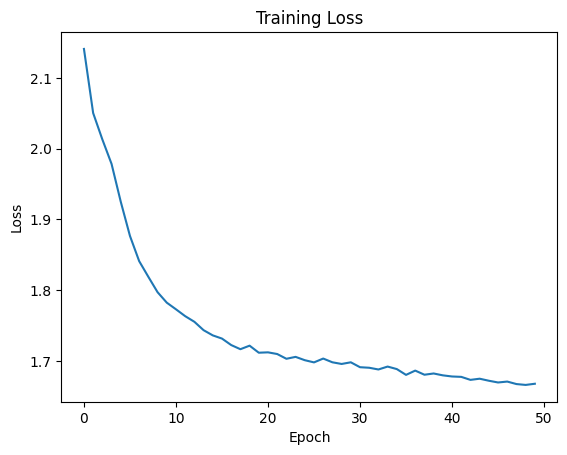

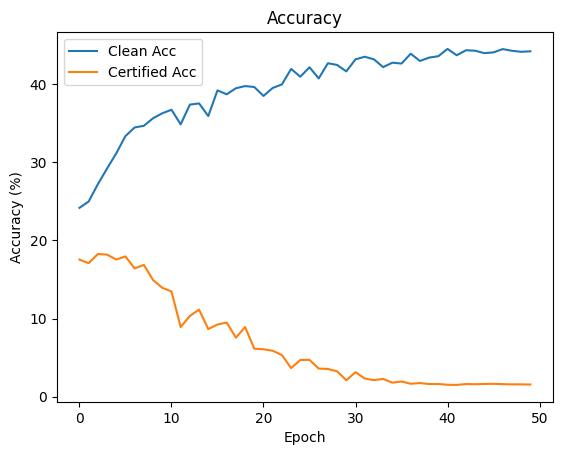

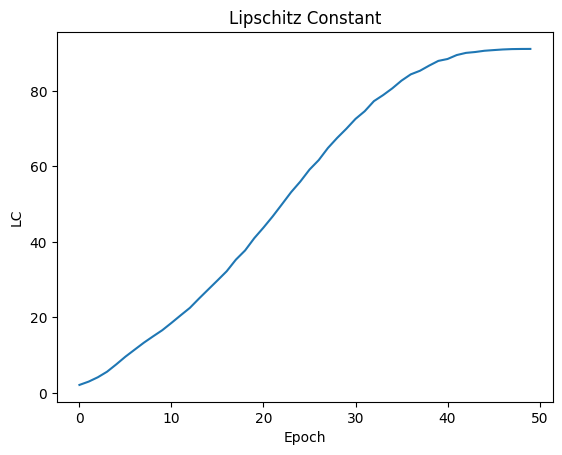

Saved lipsformer_emma.pt


In [2]:
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

def train_lipsformer():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    model = LipsFormerTransformer(embed_dim=128, depth=6, num_heads=4).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    # storage
    train_losses, clean_accs, cert_accs, lcs = [], [], [], []

    for epoch in range(50):
        # ----------------- Training -----------------
        model.train()
        running_loss = 0.0
        train_bar = tqdm(trainloader, desc=f"Epoch {epoch+1} [Train]")
        for i, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = emma_loss(model, inputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss/(i+1))

        scheduler.step()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)

        # ----------------- Evaluation -----------------
        model.eval()
        correct, cert = 0, 0
        lc = model.get_lc()
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()

                true_logit = out.gather(1, y.view(-1,1)).squeeze()
                other_max = out.scatter(1, y.view(-1,1), -float('inf')).max(1)[0]
                gap = true_logit - other_max
                cert += (gap > lc * 8/255).sum().item()

        acc = correct / len(testset)
        cert_acc = cert / len(testset)
        clean_accs.append(acc)
        cert_accs.append(cert_acc)
        lcs.append(lc)

        print(f"Epoch {epoch+1}: loss {avg_loss:.4f} | "
              f"Acc {acc*100:.2f}% | Certified {cert_acc*100:.2f}% | LC {lc:.2f}")

    # save logs to CSV
    with open("lipsformer_metrics.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "TrainLoss", "CleanAcc", "CertAcc", "LipschitzConst"])
        for i in range(len(train_losses)):
            writer.writerow([
                i+1,
                train_losses[i],
                clean_accs[i]*100,
                cert_accs[i]*100,
                lcs[i]
            ])

    # plots
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.plot([c*100 for c in clean_accs], label="Clean Acc")
    plt.plot([v*100 for v in cert_accs], label="Certified Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

    plt.plot(lcs)
    plt.title("Lipschitz Constant")
    plt.xlabel("Epoch")
    plt.ylabel("LC")
    plt.show()

    # save final model
    torch.save(model.state_dict(), 'lipsformer_emma.pt')
    print('Saved lipsformer_emma.pt')

    return model, (train_losses, clean_accs, cert_accs, lcs)


if __name__ == "__main__":
    train_lipsformer()